In [1]:
## Code adapted from https://github.com/LennonLab/ScalingMicroBiodiversity Fig1.py by CM

In [2]:
from __future__ import division
import  matplotlib.pyplot as plt
import pandas as pd
import linecache
import numpy as np
import os
import sys
import scipy.stats as stats
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import summary_table

In [3]:
## Make read-based N subsurface dataframe and fit
def plot_ci_pi(x,y,fillcolor,edgecolor,transparency,includePI,includeCI):
    dt = pd.DataFrame({'N': x})
    dt['y'] = y
    regfit = smf.ols('y ~ N',dt).fit()
    r2 = regfit.rsquared
    params = regfit.params
    a=params[0]
    b = params[1]
    st, data, ss2 = summary_table(regfit, alpha =0.05)

    fittedvalues = data[:,2]
    predict_mean_se  = data[:,3]
    predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
    predict_ci_low, predict_ci_upp = data[:,6:8].T

    data_intervals = {'N': x, 'predict_low': predict_ci_low, 'predict_upp': predict_ci_upp, 'conf_low': predict_mean_ci_low, 'conf_high': predict_mean_ci_upp}
    df_intervals = pd.DataFrame(data=data_intervals)
    df_intervals_sort = df_intervals.sort_values(by='N')

    plt.scatter(x,y,color = fillcolor, alpha= transparency , s = 8, linewidths=0.5, edgecolor=edgecolor)
    plt.plot(x, fittedvalues, '-', lw=2, color = fillcolor)
    
    if 'yes' in includePI:
        plt.plot(df_intervals_sort['N'], df_intervals_sort['predict_low'], '--', lw=1, color = fillcolor)
        plt.plot(df_intervals_sort['N'], df_intervals_sort['predict_upp'], '--', lw=1, color = fillcolor)
    if 'yes' in includeCI:
        plt.fill_between(df_intervals_sort['N'], df_intervals_sort['conf_high'], df_intervals_sort['conf_low'], color=fillcolor, alpha = 0.5,lw=0.0)

    return r2, a, b


In [4]:
## Used to plot S~Ncells
def sn_ci_pi(dt,type, fillcolor,edgecolor,transparency,includePI,includeCI,md,legendtitle):
    dt['x']= np.log10(dt['Total.Cells'])
    dt['y'] = np.log10(dt[type])
    regfit = smf.ols('y ~ x',dt).fit()
    r2 = regfit.rsquared
    print '\n\n\n\nS~Ncells'
    print regfit.summary()
    params = regfit.params
    a=params[0]
    b = params[1]
    st, data, ss2 = summary_table(regfit, alpha =0.05)

    fittedvalues = data[:,2]
    predict_mean_se  = data[:,3]
    predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
    predict_ci_low, predict_ci_upp = data[:,6:8].T

    data_intervals = {'x': dt['x'], 'predict_low': predict_ci_low, 'predict_upp': predict_ci_upp, 'conf_low': predict_mean_ci_low, 'conf_high': predict_mean_ci_upp}
    df_intervals = pd.DataFrame(data=data_intervals)
    df_intervals_sort = df_intervals.sort_values(by='x')

    for kind in md:
        d = dt.loc[dt['primer']==kind]
        plt.scatter(d.x, d.y,marker = md[kind],color = fillcolor, alpha= transparency , s = 25, linewidths=0.5, edgecolor=edgecolor,label=None)		

    if 'yes' in includePI:
        plt.plot(df_intervals_sort['x'], df_intervals_sort['predict_low'], '--', lw=1, color = fillcolor)
        plt.plot(df_intervals_sort['x'], df_intervals_sort['predict_upp'], '--', lw=1, color = fillcolor)
    if 'yes' in includeCI:
        plt.fill_between(df_intervals_sort['x'], df_intervals_sort['conf_high'], df_intervals_sort['conf_low'], color=fillcolor, alpha = 0.5,lw=0.0)

    return r2, a, b


In [5]:
## Distance-decay plot
def special_plot_ci_pi(dt,variabletype,var,color,linetype,transparency,includeCI,md,includePI):
    dt['N'] = np.log10(dt['x'])
    dt['y'] = dt['similarity']
    dt = dt.loc[dt[variabletype]==var]
    regfit = smf.ols('y ~ N',dt).fit()
    r2 = regfit.rsquared
    params = regfit.params
    a=params[0]
    b = params[1]
    st, data, ss2 = summary_table(regfit, alpha =0.05)

    fittedvalues = data[:,2]
    predict_mean_se  = data[:,3]
    predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
    predict_ci_low, predict_ci_upp = data[:,6:8].T

    data_intervals = {'N':  dt['N'], 'predict_low': predict_ci_low, 'predict_upp': predict_ci_upp, 'conf_low': predict_mean_ci_low, 'conf_high': predict_mean_ci_upp}
    df_intervals = pd.DataFrame(data=data_intervals)
    df_intervals_sort = df_intervals.sort_values(by='N')

    plt.plot(dt['N'], fittedvalues, linetype, lw=1, color = color) #,label=legendtitle)
    
    for kind in md:
        d = dt.loc[dt['primer']==kind]
        plt.scatter(d.N, d.y,marker = md[kind],color = 'white',edgecolor = 'black', alpha= 1 , s = 25, linewidths=0.5,label=None)				
        plt.scatter(d.N, d.y,marker = md[kind],color = color,edgecolor = 'black', alpha= transparency , s = 25, linewidths=0.5,label=None)	

    if 'yes' in includeCI:
        plt.fill_between(df_intervals_sort['N'], df_intervals_sort['conf_high'], df_intervals_sort['conf_low'], color=color, alpha = 0.25,lw=0.0)


    if 'yes' in includePI:
        plt.plot(df_intervals_sort['N'], df_intervals_sort['predict_low'], '--', lw=1, color = color)
        plt.plot(df_intervals_sort['N'], df_intervals_sort['predict_upp'], '--', lw=1, color = color)


    return r2, a, b


In [6]:
def Fig1(condition, ones, sampling):
    
## Declare whether or not to use singleton data
    tail = str()
    if ones is False:
        tail = '-SADMetricData_NoMicrobe1s.txt'
    elif ones is True:
        tail = '-SADMetricData.txt'
    datasets = []
    GoodNames = []
    emp = str()

## Declare whether to use open or closed reference OTU clustering
    if condition == 'open':
        emp = 'EMPopen'
        subsurface = 'SUBopen'
    elif condition == 'closed': 
        emp = 'EMPclosed'
        subsurface = 'SUBclosed'

## GoodNames is a variable designating subdirectories to use from Locey and Lennon (2016)'s micro directory
    GoodNames = [emp, 'HMP', 'BIGN', 'TARA', 'BOVINE', 'HUMAN', 'LAUB', 'SED', 'CHU', 'CHINA', 'CATLIN', 'FUNGI', 'HYDRO',  'BBS', 'CBC', 'MCDB', 'GENTRY', 'FIA']

## Add subsurface data N=reads
    GoodNames.append(subsurface)

## Add subsurface data N=cells
    GoodNames.append('nSUBopen')
    GoodNames.append('nSUBclosed')

    for name in os.listdir(mydir +'data/micro'):
        if name in GoodNames: pass
        else: continue

        path = mydir+'data/micro/'+name+'/'+name+tail
        num_lines = sum(1 for line in open(path))
        datasets.append([name, 'micro', num_lines])
        print name, num_lines


## Replace searching the LL2016 macro folder with using subsurface data

    for name in os.listdir(mydir +'data/subsurface'):
        if name in GoodNames: pass
        else: continue

        path = mydir+'data/subsurface/'+name+'/'+name+tail
        num_lines = sum(1 for line in open(path))
        datasets.append([name, 'subsurface', num_lines])
        print name, num_lines

    for name in os.listdir(mydir +'data/nsubsurface'):
        if name in GoodNames: pass
        else: continue

        path = mydir+'data/nsubsurface/'+name+'/'+name+tail
        num_lines = sum(1 for line in open(path))
        datasets.append([name, 'nsubsurface', num_lines])
        print name, num_lines

    metrics = ['Rarity, '+r'$log_{10}$',
            'Dominance, '+r'$log_{10}$',
            'Evenness, ' +r'$log_{10}$',
            'Richness, ' +r'$log_{10}$',] #+r'$(S)^{2}$']

    fig = plt.figure(figsize=(11.69,8.27))
    fs = 8 # font size used across figures

    subplotdictionary = {1:0,3:1}
   
## Go through each index and generate a plot    
    for index, i in enumerate(metrics):
        if index in set([1,3]):        
            fig.add_subplot(2, 2, subplotdictionary[index]+1)
        metric = i

## The heading Mac now corresponds to subsurface data, N=reads, being pulled in from the subsurface directory
        MicIntList, MicCoefList, MacIntList, MacCoefList, R2List, metlist = [[], [], [], [], [], []]


        Nlist, Slist, Evarlist, ESimplist, klist, radDATA, BPlist, NmaxList, rareSkews, KindList, StdList = [[], [], [], [], [], [], [], [], [], [], []]

### ORIGINAL CODE used an iterative approach to obtain fits for micro data. It would select a subset of each micro subdirectory samples, assigning them to a variable numlines

        Nlist, Slist, Evarlist, ESimplist, klist, radDATA, BPlist, NmaxList, rareSkews, KindList, StdList = [[], [], [], [], [], [], [], [], [], [], []]

        numMac = 0
        numMic = 0
        radDATA = []

## Build data structure to work with in matplotlib
        for dataset in datasets:

            name, kind, numlines = dataset

            lines = range(1, numlines+1) 
            
            path = mydir+'data/'+kind+'/'+name+'/'+name+tail

            for line in lines:
                data = linecache.getline(path, line)
                radDATA.append(data)



## CM adjustment. Highlight TARA Oceans, HMP, subsurface, nsubsurface datasets

        TARAind = []
        HMPind = []
        LAUBind = []
        HYDROind = []
        subsurfaceInd = []
        nsubsurfaceOpenInd = []
        nsubsurfaceClosedInd = []

        for ti,data in enumerate(radDATA):

            data = data.split()
            name, kind, N, S, Var, Evar, ESimp, EQ, O, ENee, EPielou, EHeip, BP, SimpDom, Nmax, McN, skew, logskew, chao1, ace, jknife1, jknife2, margalef, menhinick, preston_a, preston_S = data

            N = float(N)
            S = float(S)

            Nlist.append(float(np.log10(N)))
            Slist.append(float(np.log10(S)))

            ESimplist.append(float(np.log10(float(ESimp))))

            KindList.append(kind)

            BPlist.append(float(BP))
            NmaxList.append(float(np.log10(float(Nmax))))

            # log-modulo transformation of skewnness
            lms = np.log10(np.abs(float(skew)) + 1)
            if skew < 0: lms = lms * -1
            rareSkews.append(float(lms))

            if name == 'TARA':
                TARAind.append(ti)
            if name == 'HMP':
                HMPind.append(ti)
            if name == 'HYDRO':
                HYDROind.append(ti)
            if name == 'LAUB':
                LAUBind.append(ti)

            if kind == 'subsurface':
                subsurfaceInd.append(ti)
            if kind == 'nsubsurfaceopen':
                nsubsurfaceOpenInd.append(ti)
            if kind == 'nsubsurfaceclosed':
                nsubsurfaceClosedInd.append(ti)


        if index == 0: metlist = list(rareSkews)
        elif index == 1: metlist = list(NmaxList)
        elif index == 2: metlist = list(ESimplist)
        elif index == 3: metlist = list(Slist)

        # Multiple regression LL
        
        ## Build dataframe
        d = pd.DataFrame({'N': list(Nlist)})
        d['y'] = list(metlist)
        d['Kind'] = list(KindList)

        ## PREPARE TO PLOT
        print 'On Index %d'%index

        if index == 1:
            plt.ylim(0, 8)
            plt.xlim(0, 8.5)

        elif index == 3:
            plt.ylim(0.9, 5.0)
            plt.xlim(0, 8.5)


#####
##        ## Get 95% prediction interval of micro data
######

        ## Define micro subset
        MicListX = []
        MicListY = []

        for j, k in enumerate(KindList):
            if k == 'micro':
                MicListX.append(Nlist[j])
                MicListY.append(metlist[j])

        SUBd = d.loc[d['Kind'] == 'subsurface']
        SUBdX = [Nlist[i] for i in subsurfaceInd]
        SUBdY =[metlist[i] for i in subsurfaceInd]

## Make cell-based N subsurface dataframe and fit
        
        cOpenSUBd = d.loc[d['Kind'] == 'nsubsurfaceopen']
        cOpenSUBdX = [Nlist[i] for i in nsubsurfaceOpenInd]
        cOpenSUBdY =[metlist[i] for i in nsubsurfaceOpenInd]

        cClosedSUBd = d.loc[d['Kind'] == 'nsubsurfaceclosed']
        cClosedSUBdX = [Nlist[i] for i in nsubsurfaceClosedInd]
        cClosedSUBdY =[metlist[i] for i in nsubsurfaceClosedInd]


        TaraListX = [Nlist[i] for i in TARAind]
        TaraListY = [metlist[i] for i in TARAind]

        HMPListX = [Nlist[i] for i in HMPind]
        HMPListY = [metlist[i] for i in HMPind]

        HYDROListX = [Nlist[i] for i in HYDROind]
        HYDROListY = [metlist[i] for i in HYDROind]
        
        LAUBListX = [Nlist[i] for i in LAUBind]
        LAUBListY = [metlist[i] for i in LAUBind]



         
        
        if index in set([1,3]):
        
            plt.scatter(MicListX, MicListY, color = 'Grey', alpha= 0.15 , s = 8, linewidths=0.5, edgecolor='Grey')
            HMPR2, HMPA, HMPB = plot_ci_pi(HMPListX, HMPListY,'blue','SteelBlue',0.6,'no','no')
            LAUBR2, LAUBA, LAUBB = plot_ci_pi(LAUBListX, LAUBListY,'limegreen','SteelBlue',0.6,'no','no')
            SUBdR2, SUBdA, SUBdB = plot_ci_pi(SUBdX,SUBdY,'red','Crimson',0.8,'yes','yes')

            print 'subsurface reads = %f*N^%f' %(round(10**SUBdA,2), round(SUBdB,2))
            print 'Soil = %f*N^%f' %(round(10**LAUBA,2), round(LAUBB,2))
            print 'HMP = %f*N^%f' %(round(10**HMPA,2), round(HMPB,2))
            plt.xlabel('$log$'+r'$_{10}$'+'($N$)', fontsize=fs+2)
            plt.ylabel(metric, fontsize=fs+2)
            plt.tick_params(axis='both', which='major', labelsize=fs-3)


        def graph(formula, x_range):  
            x = np.array(x_range)  
            y = eval(formula)
            plt.plot(x, y, ls = ':', lw=3, c='Black',alpha=0.5)  

        def graphS(formula, x_range):  
            x = np.array(x_range)
            y = eval(formula)
            plt.plot(x[:len(x_range)-1]  , y[1:], ls = ':', lw=3, c='Black',alpha=0.5)  


        
        if index == 0:
            print 'do nothing'

        elif index == 1:
            graph('np.log10(0.47*(10**x)**0.92)',range(13))
            if len(str(round(SUBdR2,2))) ==3:
                SUBdR2 = str(round(SUBdR2,2))+'0'
            plt.text(0.35, 7, r'$Subsurface$; '  + r'$N_{reads}$'+ ' $R^2$'+ '=' + SUBdR2, fontsize=fs, color='red')
            plt.text(0.35, 6,  r'$Soil$; '+ ' $R^2$' + '=' + str(round(LAUBR2,2)), fontsize=fs, color='limegreen')
            plt.text(0.35, 5,  r'$HMP$; '+ ' $R^2$' + '=' + str(round(HMPR2,2)), fontsize=fs, color='blue')

        elif index == 2:
            print 'do nothing'
            
        elif index == 3:
            graphS('np.log10(1.72*(10**x)**0.39)',range(13))


            plt.text(0.35, 4.5, r'$Subsurface$; '  + r'$N_{reads}$'+ ' $R^2$'+ '=' + str(round(SUBdR2,2)), fontsize=fs, color='red')
            plt.text(0.35, 4.0,  r'$Soil$; '+ ' $R^2$' + '=' + str(round(LAUBR2,2)), fontsize=fs, color='limegreen')
            plt.text(0.35, 3.5,  r'$HMP$; '+ ' $R^2$' + '=' + str(round(HMPR2,2)), fontsize=fs, color='blue')


######## Plot S~Ncells fit and confidence interval
        if index == 3:
            fig.add_subplot(2, 2, 3)
            plt.ylim(0.9, 5.0)
            plt.xlim(6, 12.5)
            cClosedSUBdR2, cClosedSUBdA, cClosedSUBdB = plot_ci_pi(cClosedSUBdX,cClosedSUBdY,'maroon','Crimson',0,'no','yes')
            plt.text(12.2, 1.2, r'$Subsurface$; '  + r'$N_{cells}$'+ ' $R^2$' + '=' + str(round(cClosedSUBdR2,2)), fontsize=fs, color='maroon', ha='right')

######## Plot S~Ncells scatter --- with primer info

    
    df = pd.read_csv(mydir + 'data/SubsurfaceVolumes/OTU_S_Ncells.csv')
    
    mkr_dict = {'v1v3': 'h', 'v3v5': '+', 'v4v5': '^', 'v6':'o','v6v4':'D'}
    R2, A, B = sn_ci_pi(df,'closedref','maroon','Crimson',0.75,'no','no',mkr_dict, r'nothing to be here')#r'closed reference OTUs; $R^2=0.21$')


    plt.text(6.2,4.7, '16S rRNA gene primers')
    plt.scatter(6.3, 4.4, marker = 'h', color = 'black', s = 32, linewidths=0.5)
    plt.text(6.5,4.33, 'V1V3',fontsize=8)
    plt.scatter(7.3, 4.4, marker = '+', color = 'black', s = 32, linewidths=0.5)
    plt.text(7.5,4.33, 'V3V5',fontsize=8)
    plt.scatter(8.3, 4.4, marker = '^', color = 'black', s = 32, linewidths=0.5)
    plt.text(8.5,4.33, 'V4V5',fontsize=8)
    plt.scatter(9.3, 4.4, marker = 'D', color = 'black', s = 28, linewidths=0.5)
    plt.text(9.5,4.33, 'V6V4',fontsize=8)
    plt.scatter(10.3, 4.4, marker = 'o', color = 'black', s = 32, linewidths=0.5)
    plt.text(10.5,4.33, 'V6',fontsize=8)


    plt.xlabel('$log$'+r'$_{10}$'+'($N_{cells}$)', fontsize=fs+2)
    plt.ylabel('Richness, ' +r'$log_{10}$', fontsize=fs+2)
    plt.tick_params(axis='both', which='major', labelsize=fs-3)


### Plot distance-decay
    fig.add_subplot(2, 2, 4)
    plt.ylim(0, 1)
    plt.xlim(-2.5, 3)
    
    df = pd.read_csv(mydir + 'data/SubsurfaceDistanceDecay/closedref_distance_sorensen_Depth_no_0_orderMag_one_icelandic_primer.csv')
    
    mkr_dict = {'v1v3': 'h', 'v3v5': '+', 'v6':'o','v6v4':'D','different primers': '*', 'v4v5': '^'}
    colordict = {'FennoScandian Shield': 'cyan', 'different regions': 'black', 'USA': 'magenta', 'South Africa':'orange','Iceland':'darkgoldenrod'}

    markerList = []
    colorList = []

    for item in df['primer']:
        markerList.append(mkr_dict[item])
    for item in df['locality']:
        colorList.append(colordict[item])

    df['marker']=markerList
    df['color']=colorList


    R2,A,B = special_plot_ci_pi(df,'locality','South Africa','slateblue','-',0.9,'yes',mkr_dict,'no')
    plt.text(2.80,0.30, r'$South$ $Africa$; ' + r'$R^2 = $' + str(round(R2,2)), fontsize=fs, color='slateblue', ha='right')
    R2,A,B = special_plot_ci_pi(df,'locality','Iceland','orange','-',0.9,'yes',mkr_dict,'no')
    plt.text(2.80,0.22, r'$Iceland$; ' + r'$R^2 = $' + str(round(R2,2)), fontsize=fs, color='peru', ha='right')
    R2,A,B = special_plot_ci_pi(df,'locality','FennoScandian Shield','teal','-',0.9,'yes',mkr_dict,'no')
    plt.text(2.80,0.14, r'$Olkiluoto$; ' + r'$R^2 = $' + str(round(R2,2)), fontsize=fs, color='teal', ha='right')
    R2,A,B = special_plot_ci_pi(df,'locality','USA','magenta','-',0.9,'yes',mkr_dict,'no')
    plt.text(2.80,0.06, r'$Wallula$; ' + r'$R^2 = $' + str(round(R2,2)), fontsize=fs, color='magenta', ha='right')

    
    plt.xlabel('Distance in km, $log$'+r'$_{10}$'+'(km)', fontsize=fs+2)
    plt.ylabel('Sorensen similarity', fontsize=fs+2)
    plt.tick_params(axis='both', which='major', labelsize=fs-3)

    
    plt.subplots_adjust(wspace=0.4, hspace=0.4)


    plt.show()
    plt.close()

    return


BIGN 13
BOVINE 15
CATLIN 129
CHINA 186
CHU 43
EMPclosed 14462
FUNGI 127
HMP 4303
HUMAN 525
HYDRO 117
LAUB 79
SED 34
TARA 139
SUBclosed 51
nSUBclosed 51
nSUBopen 51
On Index 0
do nothing
On Index 1
subsurface reads = 0.260000*N^1.000000
Soil = 1.380000*N^0.690000
HMP = 0.300000*N^1.010000
On Index 2
do nothing
On Index 3
subsurface reads = 0.340000*N^0.690000
Soil = 0.420000*N^0.820000
HMP = 3.850000*N^0.290000




S~Ncells
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     3.496
Date:                Tue, 31 Jul 2018   Prob (F-statistic):             0.0675
Time:                        15:16:54   Log-Likelihood:                -49.270
No. Observations:                  51   AIC:                             102.5
Df Residuals:       

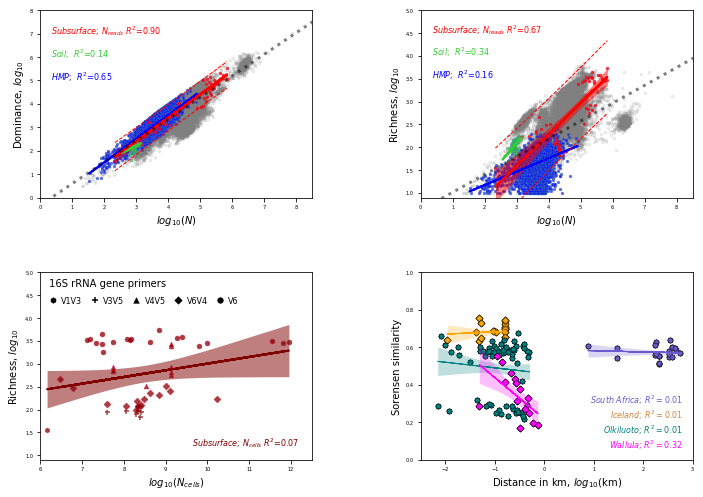

In [7]:
mydir = os.path.expanduser("~/Desktop/ScalingMicroBiodiversity-master/")

EMPcondition = ['closed']
Singletons = [False]
Samplings = [100]

for condition in EMPcondition:
    for ones in Singletons:
        for sampling in Samplings:
            Fig1(condition, ones, sampling)
